## Aula 02 - Exercícios

In [27]:
import pandas as pd
import numpy as np

### Importar base de dados

In [28]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar.gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [29]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [30]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [31]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

In [36]:
import numpy as np
from math import sqrt

def train_svdpp(train, n_factors, lr=0.01, reg=0.02, miter=10) :

    #inicializando as variáveis necessárias
    global_mean = train['rating'].mean()
    n_users = df['userId'].max()+1
    n_items = df['movieId'].max()+1

    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))
    #novas com relação ao otimizado
    y = np.random.normal(0.1, 0.1, (n_items, n_factors))
    user_items = train.groupby('userId')['movieId'].apply(list).to_dict()

    train_error = []

    #loop de treino
    for t in range(miter):
        sq_error = 0
        for index, row in train.iterrows():
            u = row['userId']
            i = row['movieId']
            r_ui = row['rating']
            
            R_u = user_items.get(u, [])
            sqrt_R_u = sqrt(len(R_u)) if R_u else 1.0
            sum_y = np.sum(y[R_u], axis=0) if R_u else np.zeros(n_factors)
            imp_factor = sum_y / sqrt_R_u
            
            pred = global_mean + bu[u] + bi[i] + np.dot(q[i], p[u] + imp_factor)
            e_ui = r_ui - pred
            sq_error += e_ui ** 2
            
            #atualizações dos parâmetros
            bu[u] += lr * (e_ui - reg * bu[u])
            bi[i] += lr * (e_ui - reg * bi[i])
            delta_q = e_ui * (p[u] + imp_factor) - reg * q[i]
            delta_p = e_ui * q[i] - reg * p[u]
            
            q[i] += lr * delta_q
            p[u] += lr * delta_p

            for j in R_u:
                y[j] += lr * (e_ui * q[i] / sqrt_R_u - reg * y[j])
        
        train_error.append(sqrt(sq_error / len(train)))
        print(f"Iteração {t+1}: RMSE = {train_error[-1]:.4f}")
    
    return global_mean, bu, bi, p, q, y, train_error

    

***b)*** Plote a curva de aprendizado de seu modelo.

In [37]:
gl, bu, bi, p, q, y, error = train_svdpp(train, 2, miter=30)

Iteração 1: RMSE = 0.9024
Iteração 2: RMSE = 0.8644
Iteração 3: RMSE = 0.8426
Iteração 4: RMSE = 0.8258
Iteração 5: RMSE = 0.8119
Iteração 6: RMSE = 0.8000
Iteração 7: RMSE = 0.7896
Iteração 8: RMSE = 0.7803
Iteração 9: RMSE = 0.7721
Iteração 10: RMSE = 0.7647
Iteração 11: RMSE = 0.7581
Iteração 12: RMSE = 0.7520
Iteração 13: RMSE = 0.7464
Iteração 14: RMSE = 0.7411
Iteração 15: RMSE = 0.7361
Iteração 16: RMSE = 0.7316
Iteração 17: RMSE = 0.7274
Iteração 18: RMSE = 0.7238
Iteração 19: RMSE = 0.7205
Iteração 20: RMSE = 0.7177
Iteração 21: RMSE = 0.7152
Iteração 22: RMSE = 0.7130
Iteração 23: RMSE = 0.7111
Iteração 24: RMSE = 0.7094
Iteração 25: RMSE = 0.7078
Iteração 26: RMSE = 0.7065
Iteração 27: RMSE = 0.7052
Iteração 28: RMSE = 0.7041
Iteração 29: RMSE = 0.7030
Iteração 30: RMSE = 0.7020


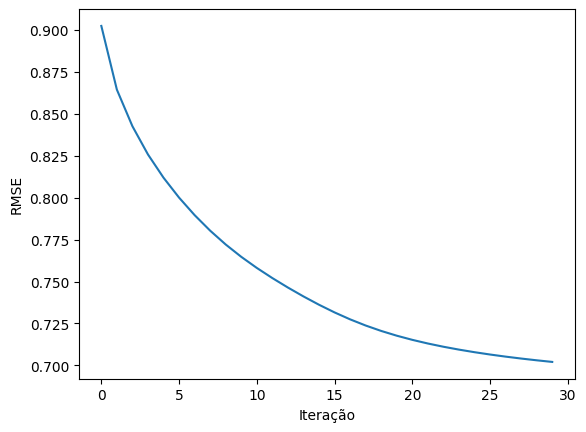

In [38]:
import matplotlib.pyplot as plt

plt.plot(error)
plt.xlabel('Iteração')
plt.ylabel('RMSE')
plt.show()

***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [39]:
test.head()

,userId,movieId,rating,title
31477,1836,60,2.5,She's the Man (2006)
148621,8646,33,3.5,North by Northwest (1959)
25190,1464,19,4.5,Reservoir Dogs (1992)
91518,5315,33,5.0,North by Northwest (1959)
113446,6571,18,4.0,Life Is Beautiful (La Vita è bella) (1997)


In [40]:
#pred = gl + b_u + b_i + q_i · (p_u + |R_u|^(-1/2) * soma(y_j))

def predict_svdpp(user_id, item_id, user_items):
    R_u = user_items.get(user_id, [])
    sqrt_R_u = np.sqrt(len(R_u)) if R_u else 1.0
    sum_y = np.sum(y[R_u], axis=0) if R_u else np.zeros(p.shape[1])
    imp_factor = sum_y / sqrt_R_u

    pred = gl + bu[user_id] + bi[item_id] + np.dot(q[item_id], p[user_id] + imp_factor)
    return pred


print(predict_svdpp(1836, 60, test))
print(predict_svdpp(8646, 33, test))
print(predict_svdpp(1464, 19, test))
print(predict_svdpp(5315, 33, test))
print(predict_svdpp(6571, 18, test))
#suficientemente perto
#errou para o quarto

2.253034691271281
3.29207412594854
4.117507154125138
3.6018632927933294
3.713533307290844


**Exercício 02**: Utilizando o código do NCF visto na aula, compare o desempenho entre as instâncias GMF, MLP e NeuMF nesta base de dados (ml-20m-compact).

In [50]:
import torch
import torch.nn as nn

class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        nn.Module.__init__(self)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
                 
        # COMENTAR SE FOR USAR NeuMF       
        # Definir a camada de saída
        self.output = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
        # COMENTAR SE FOR USAR NeuMF
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        output = user_emb * item_emb  # Produto de Hadamard
        
        # COMENTAR SE FOR USAR NeuMF
        # Passar pela camada de saída e aplicar sigmoid
        output = self.sigmoid(self.output(output))
        # COMENTAR SE FOR USAR NeuMF
        
        return output


class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, layers=[64,32,16,8]):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        
        mlp_layers = []
        input_size = embedding_dim * 2
        for output_size in layers:
            mlp_layers.append(nn.Linear(input_size, output_size))
            mlp_layers.append(nn.ReLU())
            input_size = output_size
        
        self.mlp = nn.Sequential(*mlp_layers)
        self.output = nn.Linear(layers[-1], 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user, item):
        user_emb = self.user_embed(user)
        item_emb = self.item_embed(item)
        concat = torch.cat([user_emb, item_emb], dim=-1)
        mlp_out = self.mlp(concat)
        return self.sigmoid(self.output(mlp_out))


In [53]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, layers=[64,32,16,8]):
        super().__init__()
        # GMF component
        self.gmf_user_embed = nn.Embedding(num_users, embedding_dim)
        self.gmf_item_embed = nn.Embedding(num_items, embedding_dim)
        self.gmf_output = nn.Linear(embedding_dim, 1)
        
        # MLP component
        self.mlp_user_embed = nn.Embedding(num_users, embedding_dim)
        self.mlp_item_embed = nn.Embedding(num_items, embedding_dim)
        
        mlp_layers = []
        input_size = embedding_dim * 2
        for output_size in layers:
            mlp_layers.append(nn.Linear(input_size, output_size))
            mlp_layers.append(nn.ReLU())
            input_size = output_size
        
        self.mlp = nn.Sequential(*mlp_layers)
        self.mlp_output = nn.Linear(layers[-1], 1)
        
        # Final output
        self.output = nn.Linear(2, 1)  # Combina GMF (1) + MLP (1)
        self.sigmoid = nn.Sigmoid()
        
        # Inicialização
        nn.init.normal_(self.gmf_user_embed.weight, std=0.01)
        nn.init.normal_(self.gmf_item_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_user_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embed.weight, std=0.01)

    def forward(self, user, item):
        # GMF
        gmf_u = self.gmf_user_embed(user)
        gmf_i = self.gmf_item_embed(item)
        gmf_interaction = gmf_u * gmf_i  # Produto de Hadamard
        gmf_out = self.gmf_output(gmf_interaction)
        
        # MLP
        mlp_u = self.mlp_user_embed(user)
        mlp_i = self.mlp_item_embed(item)
        mlp_concat = torch.cat([mlp_u, mlp_i], dim=-1)
        mlp_out = self.mlp_output(self.mlp(mlp_concat))
        
        # NeuMF
        combined = torch.cat([gmf_out, mlp_out], dim=-1)
        return self.sigmoid(self.output(combined))



Treinando GMF
GMF - Epoch 1: Loss = 0.0559
GMF - Epoch 2: Loss = 0.0307
GMF - Epoch 3: Loss = 0.0263
GMF - Epoch 4: Loss = 0.0244
GMF - Epoch 5: Loss = 0.0228
GMF - Epoch 6: Loss = 0.0203
GMF - Epoch 7: Loss = 0.0174
GMF - Epoch 8: Loss = 0.0146
GMF - Epoch 9: Loss = 0.0118
GMF - Epoch 10: Loss = 0.0094
GMF - Epoch 11: Loss = 0.0075
GMF - Epoch 12: Loss = 0.0062
GMF - Epoch 13: Loss = 0.0053
GMF - Epoch 14: Loss = 0.0046
GMF - Epoch 15: Loss = 0.0042
GMF - Epoch 16: Loss = 0.0039
GMF - Epoch 17: Loss = 0.0036
GMF - Epoch 18: Loss = 0.0034
GMF - Epoch 19: Loss = 0.0032
GMF - Epoch 20: Loss = 0.0031

Treinando MLP
MLP - Epoch 1: Loss = 0.0370
MLP - Epoch 2: Loss = 0.0328
MLP - Epoch 3: Loss = 0.0319
MLP - Epoch 4: Loss = 0.0307
MLP - Epoch 5: Loss = 0.0292
MLP - Epoch 6: Loss = 0.0279
MLP - Epoch 7: Loss = 0.0269
MLP - Epoch 8: Loss = 0.0260
MLP - Epoch 9: Loss = 0.0252
MLP - Epoch 10: Loss = 0.0246
MLP - Epoch 11: Loss = 0.0240
MLP - Epoch 12: Loss = 0.0235
MLP - Epoch 13: Loss = 0.023

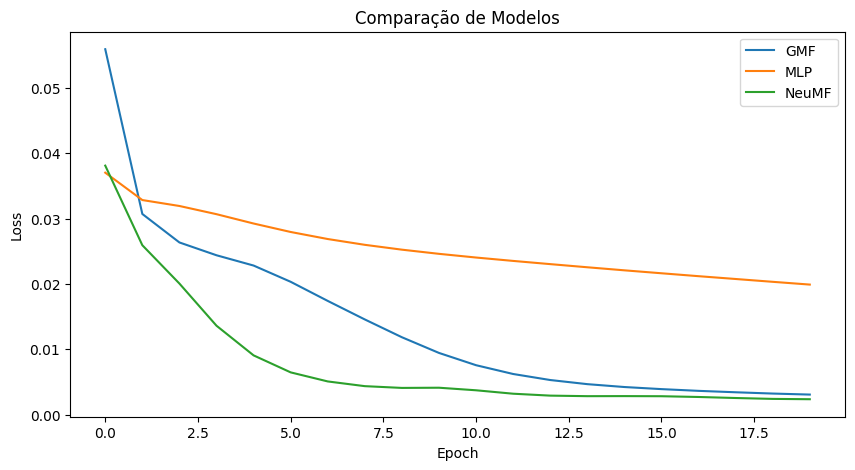

In [54]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

#Carregar dados
df = pd.read_csv('ml-20m-compact/dataset/ratings_sample.csv')
df = df[['userId', 'movieId', 'rating']]

#Converter para índices consecutivos
df['user_idx'] = df['userId'].astype('category').cat.codes
df['movie_idx'] = df['movieId'].astype('category').cat.codes

#Divisão treino/teste
train, test = train_test_split(df, test_size=0.2, random_state=42)

#Criar DataLoaders
def create_loader(data):
    users = torch.LongTensor(data['user_idx'].values)
    items = torch.LongTensor(data['movie_idx'].values)
    ratings = torch.FloatTensor(data['rating'].values) / 5.0  #Normalizar para 0-1
    return DataLoader(TensorDataset(users, items, ratings), batch_size=256)

train_loader, test_loader = create_loader(train), create_loader(test)

#Definir modelos (GMF, MLP, NeuMF - use as classes que você copiou)

#Função de treinamento
def train_and_evaluate(model, name):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = []
    for epoch in range(20):
        model.train()
        epoch_loss = 0
        for users, items, ratings in train_loader:
            optimizer.zero_grad()
            preds = model(users, items).squeeze()
            loss = criterion(preds, ratings)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss/len(train_loader))
        print(f"{name} - Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}")
    
    return train_losses

#Treinar e comparar modelos
num_users = df['user_idx'].nunique()
num_items = df['movie_idx'].nunique()

models = {
    "GMF": GMF(num_users, num_items, 20),
    "MLP": MLP(num_users, num_items, 20),
    "NeuMF": NeuMF(num_users, num_items, 20)
}

results = {}
for name, model in models.items():
    print(f"\nTreinando {name}")
    results[name] = train_and_evaluate(model, name)

#Plotar resultados
plt.figure(figsize=(10,5))
for name, losses in results.items():
    plt.plot(losses, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparação de Modelos')
plt.legend()
plt.show()